In [3]:
!pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


## Trainingsdaten nach `/tmp` kopieren

Da das Homeverzeichnis des Users auf einem (langsamem) NFS-Share liegen, lohnt es sich, die Daten erst einmal nach `/tmp` zu kopieren.

In [1]:
!cp -r ./data/celeba /tmp

In [4]:
import cv2
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from tqdm.notebook import tqdm

In [5]:
image_size = 128
batch_size = 512
num_workers = 10

transform = transforms.Compose(
    [transforms.Resize((image_size, image_size)), transforms.ToTensor()])


dataset = torchvision.datasets.ImageFolder("/tmp/celeba/images", transform=transform)

In [6]:
test_dataset = torch.utils.data.Subset(dataset, range(128))
train_dataset = torch.utils.data.Subset(dataset, range(128, len(dataset)))

In [7]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers, pin_memory=True)

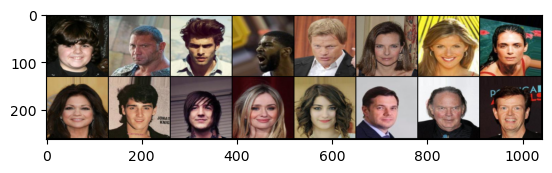

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:16]))


In [10]:
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        # Random values with standard normal distribution
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mean)

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)


In [11]:
class KLDLoss(nn.Module):
    """Calculate Kullback-Leibler divergence between learned mean and logvar and standard normal distribution.
    This is *NOT* a re-implementation of torch.nn.KLDivLoss"""
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

In [12]:
def imsave(x, rec_x, path, row=2, col=2):
    """ Save the first row*col images """

    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]
    out_imgs = (rec_x.clone().clamp(0.0, 1.0).cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
    out_imgs = cv2.vconcat([cv2.hconcat([out_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
    
    # Concat
    h, _, c = in_imgs.shape
    margin_shape = (h, 5, c)
    margin = np.ones(margin_shape, np.uint8) * 255
    concat_imgs = cv2.hconcat([in_imgs, margin, out_imgs])

    # Save
    cv2.imwrite(path, concat_imgs)

In [ ]:
epochs = 40
alpha = 1.0
beta = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = VAE(isize=image_size, nz=512, device=device).to(device)
model = VAE(isize=image_size, nef=64, ndf=64, nz=768, device=device).to(device)

reconst_criterion = nn.MSELoss(reduction='sum')
kld_criterion = KLDLoss(reduction='sum')

# Solver
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

history = {"train": [], "test": []}
test_loss = 0

# Start training
with tqdm(range(epochs)) as iterator:
    for epoch in iterator:
        # Loss
        running_loss = 0.0
        # Data num
        data_num = 0

        # Train
        model.train(True)
        for i, (x, _label) in enumerate(tqdm(trainloader)):
            # Optimize params
            optimizer.zero_grad()

            # Pass forward
            x = x.to(device)
           
            rec_x, mean, logvar = model(x)

            # Calc loss
            reconst_loss = reconst_criterion(x, rec_x)
            kld_loss = kld_criterion(mean, logvar)
            loss = alpha * reconst_loss + beta * kld_loss
            loss.backward()
            optimizer.step()

            # Visualize
            if i == 0 and x.size(0) >= 64:
                imsave(x, rec_x, os.path.join(f"epoch{epoch+1}", f"train.png"), 8, 8)
                
            # Add stats
            running_loss += loss.item()
            data_num += x.size(0)

        # Log
        train_loss = running_loss / data_num
        history["train"].append(train_loss)
        
        # Loss
        running_loss = 0.0
        # Data num
        data_num = 0 
        
        # Test
        
        model.train(False)
        for i, (x, _label) in enumerate(testloader):
            with torch.no_grad():

                # Pass forward
                x = x.to(device)
                rec_x, mean, logvar = model(x)

                # Calc loss
                reconst_loss = reconst_criterion(x, rec_x)
                kld_loss = kld_criterion(mean, logvar)
                loss = alpha * reconst_loss + beta * kld_loss

                # Visualize
                if x.size(0) >= 16:
                    imsave(x, rec_x, os.path.join(f"epoch{epoch+1}", f"test-{i}.png"), 8, 8)

            # Add stats
            running_loss += loss.item() 
            data_num += x.size(0)

        # Log
        test_loss = running_loss / data_num
        history["test"].append(test_loss)
        iterator.set_postfix_str(f"Train Loss: {train_loss:.4f} Test loss: {test_loss:.4f}")



# Save the model
torch.save(model.state_dict(), 'final_model.pth')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

In [18]:
history

{'train': [5447.23911202098,
  999.3166288320302,
  804.2674242545846,
  711.1974946412079,
  664.9748829770683,
  613.6677734866969,
  588.260559768436,
  591.6905540639153,
  562.711362367944,
  536.4889697552366,
  550.8829592802797,
  515.587502693287,
  507.46295935590774,
  499.8488813289928,
  510.0142467161964,
  488.3031813815312,
  477.80823793129633,
  477.0513810465449,
  468.7130572094275,
  468.7791615836342],
 'test': [1298.5465087890625,
  877.4542846679688,
  736.5441284179688,
  695.1629028320312,
  636.03369140625,
  597.4219360351562,
  603.1455078125,
  574.744873046875,
  553.185546875,
  539.6300048828125,
  523.01171875,
  519.1276245117188,
  523.1036987304688,
  506.732666015625,
  502.930419921875,
  478.50335693359375,
  490.76715087890625,
  474.71185302734375,
  484.8154296875,
  476.341796875]}

In [ ]:
plot_train = np.array(history["train"])
is_val = ("test" in history.keys())
if is_val:
    plot_val = np.array(history["test"])

# epochs
n_epochs = len(plot_train)

# X axis
x = [i for i in range(1, n_epochs+1)]

# plot loss
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.xlabel('epoch')
plt.yscale('log')
plt.plot(x, plot_train[:], label='train loss')
if is_val:
    plt.plot(x, plot_val[:], label='test loss')

plt.legend()
plt.savefig(os.path.join('loss.png'))